In [1]:
import json
import requests
import pandas as pd

In [53]:
# get toplist by Market Cap
BASE_URL = "https://min-api.cryptocompare.com/data/"

n = 50 # get top 50 
url = f"{BASE_URL}top/mktcapfull?limit={n}&tsym=USD"
res = requests.get(url).text
data = json.loads(res)

df_toplist = pd.DataFrame()
for i in range(n):
    df_sub = pd.DataFrame(data['Data'][i]['CoinInfo'])
    df_toplist = pd.concat([df_toplist, df_sub], axis=0)

df_toplist.head()

,Id,Name,FullName,Internal,ImageUrl,Url,Algorithm,ProofType,Rating,NetHashesPerSecond,BlockNumber,BlockTime,BlockReward,AssetLaunchDate,MaxSupply,Type,DocumentType
Weiss,1182,BTC,Bitcoin,BTC,/media/37746251/btc.png,/coins/btc/overview,SHA-256,PoW,"{'Rating': 'B+', 'TechnologyAdoptionRating': '...",914822190299551200000,883974,217.000,3.125000,2009-01-03,2.100000e+07,1,Webpagecoinp
Weiss,7605,ETH,Ethereum,ETH,/media/37746238/eth.png,/coins/eth/overview,Ethash,PoS,"{'Rating': 'B-', 'TechnologyAdoptionRating': '...",0,21855723,12.000,2.044338,2015-07-30,-1.000000e+00,1,Webpagecoinp
Weiss,5031,XRP,XRP,XRP,/media/38553096/xrp.png,/coins/xrp/overview,N/A,XRP LCP,"{'Rating': 'B-', 'TechnologyAdoptionRating': '...",0,94175195,4.000,0.000000,2012-09-26,1.000000e+11,1,Webpagecoinp
Weiss,171986,USDT,Tether,USDT,/media/37746338/usdt.png,/coins/usdt/overview,N/A,N/A,"{'Rating': '', 'TechnologyAdoptionRating': '',...",0,0,0.000,0.000000,2014-10-06,-1.000000e+00,1,Webpagecoinp
Weiss,934443,SOL,Solana,SOL,/media/37747734/sol.png,/coins/sol/overview,N/A,PoH,"{'Rating': 'D+', 'TechnologyAdoptionRating': '...",0,299207005,0.637,0.000000,2020-03-31,-1.000000e+00,1,Webpagecoinp


In [56]:
# get latest price for each top currency
df_price = pd.DataFrame()
for name in list(df_toplist['Name']):
    url = f"{BASE_URL}v2/histoday?fsym={name}&tsym=USD&limit=1"
    res = requests.get(url).text
    data = json.loads(res)
    df_sub = pd.DataFrame(data['Data']['Data'][-1], index=[name])
    df_price = pd.concat([df_price, df_sub], axis=0)

df_price.reset_index(inplace=True)
df_price.rename(columns={'index':'Name'}, inplace=True)
df_price.head()

,Name,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,BTC,1739664000,97728.270,97556.740,97596.210,375.29,36644619.79,97658.110,direct,
1,ETH,1739664000,2706.230,2690.880,2693.560,14039.31,37883217.44,2700.500,direct,
2,XRP,1739664000,2.802,2.757,2.762,16077063.46,44771202.22,2.793,direct,
3,USDT,1739664000,1.000,1.000,1.000,20537713.47,20540189.31,1.000,direct,
4,SOL,1739664000,195.490,193.420,194.520,152211.32,29599564.34,194.840,direct,


In [59]:
# merge above two dataframes
df = pd.merge(left=df_toplist, right=df_price, left_on = 'Name', right_on='Name', how='left')

rating_df = pd.json_normalize(df["Rating"])
df = pd.concat([df.drop(columns=["Rating"]), rating_df], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        50 non-null     object 
 1   Name                      50 non-null     object 
 2   FullName                  50 non-null     object 
 3   Internal                  50 non-null     object 
 4   ImageUrl                  50 non-null     object 
 5   Url                       50 non-null     object 
 6   Algorithm                 50 non-null     object 
 7   ProofType                 50 non-null     object 
 8   NetHashesPerSecond        50 non-null     object 
 9   BlockNumber               50 non-null     int64  
 10  BlockTime                 50 non-null     float64
 11  BlockReward               50 non-null     float64
 12  AssetLaunchDate           50 non-null     object 
 13  MaxSupply                 50 non-null     float64
 14  Type        

In [72]:
print(df['ProofType'].value_counts())
print(df['Algorithm'].value_counts())

N/A        34
PoS         6
PoW         5
XRP LCP     1
PoH         1
PoSA        1
DPoS        1
SCP         1
Name: ProofType, dtype: int64
N/A          42
SHA-256       2
Scrypt        2
Ethash        1
BEP-2         1
Ouroboros     1
RandomX       1
Name: Algorithm, dtype: int64


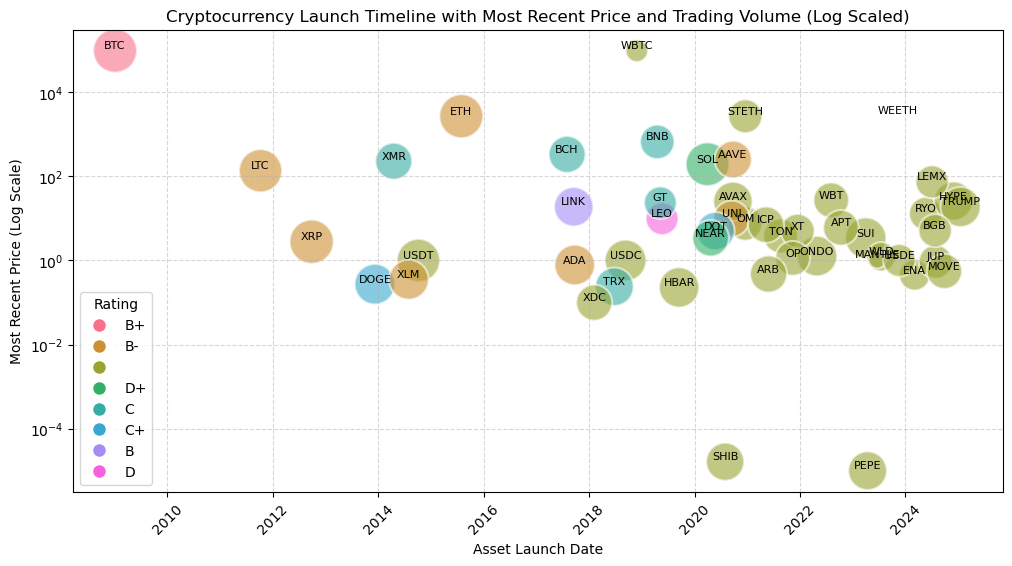

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure 'AssetLaunchDate' is in datetime format
df['AssetLaunchDate'] = pd.to_datetime(df['AssetLaunchDate'])

# Define a color palette for Ratings
unique_ratings = df['Rating'].unique()
palette = sns.color_palette("husl", len(unique_ratings))
rating_color_map = {rating: palette[i] for i, rating in enumerate(unique_ratings)}

# Log transform 'volumefrom' for bubble size
df['volumeto_log'] = np.log1p(df['volumeto'])  # Using log1p to avoid log(0) issues

# Create bubble plot
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    df['AssetLaunchDate'], 
    df['close'], 
    s=(df['volumeto_log'] / df['volumeto_log'].max()) * 1000,  # Log-transformed bubble size
    c=df['Rating'].map(rating_color_map),  # Map colors to ratings
    alpha=0.6, edgecolors="w", linewidth=1.5
)

# Add labels for each bubble
for i, row in df.iterrows():
    plt.text(row['AssetLaunchDate'], row['close'], row['Name'], fontsize=8, ha='center', va='bottom')

# Set y-axis to log scale for better visualization
plt.yscale("log")

# Add legend manually for ratings
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=rating_color_map[r], markersize=10) for r in unique_ratings]
plt.legend(handles, unique_ratings, title="Rating", loc="lower left")

# Labels and title
plt.xlabel("Asset Launch Date")
plt.ylabel("Most Recent Price (Log Scale)")
plt.title("Cryptocurrency Launch Timeline with Most Recent Price and Trading Volume (Log Scaled)")

# Show plot
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5, which="both")  # Apply grid for both major and minor ticks
plt.show()


In [81]:
df.head(10)

,Id,Name,FullName,Internal,ImageUrl,Url,Algorithm,ProofType,NetHashesPerSecond,BlockNumber,...,volumefrom,volumeto,close,conversionType,conversionSymbol,Rating,TechnologyAdoptionRating,MarketPerformanceRating,volumefrom_log,volumeto_log
0,1182,BTC,Bitcoin,BTC,/media/37746251/btc.png,/coins/btc/overview,SHA-256,PoW,914822190299551200000,883974,...,375.29,36644619.79,97658.1100,direct,,B+,A-,D,5.930360,17.416777
1,7605,ETH,Ethereum,ETH,/media/37746238/eth.png,/coins/eth/overview,Ethash,PoS,0,21855723,...,14039.31,37883217.44,2700.5000,direct,,B-,B,D,9.549688,17.450019
2,5031,XRP,XRP,XRP,/media/38553096/xrp.png,/coins/xrp/overview,N/A,XRP LCP,0,94175195,...,16077063.46,44771202.22,2.7930,direct,,B-,B-,C-,16.592904,17.617076
3,171986,USDT,Tether,USDT,/media/37746338/usdt.png,/coins/usdt/overview,N/A,N/A,0,0,...,20537713.47,20540189.31,1.0000,direct,,,,,16.837773,16.837894
4,934443,SOL,Solana,SOL,/media/37747734/sol.png,/coins/sol/overview,N/A,PoH,0,299207005,...,152211.32,29599564.34,194.8400,direct,,D+,D,C,11.933032,17.203270
5,204788,BNB,Binance Coin,BNB,/media/40485170/bnb.png,/coins/bnb/overview,BEP-2,PoSA,0,46696095,...,63.25,41945.83,662.1000,direct,,C,C,C-,4.162782,10.644158
6,925809,USDC,USD Coin,USDC,/media/34835941/usdc.png,/coins/usdc/overview,N/A,N/A,0,0,...,5824382.29,5823994.86,0.9999,direct,,,,,15.577564,15.577497
7,4432,DOGE,Dogecoin,DOGE,/media/37746339/doge.png,/coins/doge/overview,Scrypt,PoW,1889991285160212,5589078,...,10345961.31,2821094.93,0.2727,direct,,C+,B-,E+,16.152107,14.852636
8,321992,ADA,Cardano,ADA,/media/37746235/ada.png,/coins/ada/overview,Ouroboros,PoS,0,11489849,...,3316771.81,2591752.47,0.7809,direct,,B-,B,D-,15.014503,14.767845
9,953119,SUI,Sui,SUI,/media/44082045/sui.png,/coins/sui/overview,N/A,N/A,0,0,...,1330781.98,4543069.05,3.4030,direct,,,,,14.101278,15.329114
